# Kmeans cluster investigation
- looks at the expression levels of known markers (given cell-type) of specific clusters.(part 1)
- looks for number of mye&lymph conflicts in specified cluster. (part 1)
- compares expression levels across all genes between two specified clusters. (part 2)

In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
from utilities.general_helpers import *
# ------- SERVER EXTENSIONS ---------
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import yaml
from os.path import join
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import statsmodels as sm
import scipy.stats as stats
from scipy.stats import rankdata
from Bio.Cluster import kcluster
from sklearn.manifold import TSNE
import pickle
import numpy as np
from utilities.general_helpers import flatten_list
from utilities.ML_environment import find_marker_genes_in_cluster
# import pyclustering
from shutil import copyfile
import matplotlib.pyplot as plt

###### (MUST) Data path (uploading):

In [2]:
KMEANS_PATH = fr'/storage/md_keren/shitay/outputs/clustering/kmeans/row_kmeans'
tsne_path = r'/storage/md_keren/shitay/outputs/TSNE/4.5.21_cohort_immune/'
filtered_cells_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/cohort.pkl'
filtered_cells = pickle.load(open(filtered_cells_path, 'rb'))
filtered_cells = filtered_cells[filtered_cells.cells_information.getattr('is_immune')]

# empty_barcodes_path = r'/storage/md_keren/shitay/outputs/CellBender/empty_droplets_barcodes.csv'
# empty_barcodes_df = pd.read_csv(empty_barcodes_path)

Extracts wanted cluster:

In [4]:
# Extract kmeans solution (K) and cluster (cls_idx) 
K = 11
cls_idx = 7
path = join(KMEANS_PATH, f'kmeans_immune_cells_var0.315_k_{K}.pkl')
kmeans = pickle.load(open(path, 'rb'))
print(f'K = {K}')
print(f'cluster idx: {cls_idx}')

cluster_cells = filtered_cells[kmeans['clusters'][cls_idx-1]]

K = 11
cluster idx: 7


Prints how many cell having a mye & lymph conflict:

In [5]:
mye = np.array([cluster_cells.cells_information.getattr('is_myeloid')])
lym = np.array([cluster_cells.cells_information.getattr('is_lymphoid')])
# np.concatenate((mye, lym), axis=0)
print(f'number of cell in cluster: {cluster_cells.number_of_cells}')
print(f'number of mye&lymph-conflict cells: {np.sum(mye & lym )}')

number of cell in cluster: 7587
number of mye&lymph-conflict cells: 38


Prints cell-types in the given cluster that have been found during marker classification process:

In [6]:
print(f'Cell-types shown in cluster {cls_idx}, K={K}:')
sorted(Counter(flatten_list(cluster_cells.cells_information.getattr('cell_type_list'))).items(), key=lambda x: x[1], reverse=True)

Cell-types shown in cluster 7, K=11:


[('Immune_general', 3727),
 ('Neutrophils', 3411),
 ('Granolocytes', 1952),
 ('B cells', 290),
 ('T cells', 237),
 ('CD8 Cytotoxic T cells', 82),
 ('Exhausted T cells', 66),
 ('myeloid cells_general_mature', 57),
 ('cDCs_dendritic_cells', 56),
 ('CD4 helper T cells', 41),
 ('NKT cells', 29),
 ('myeloid cells_general_immature', 17),
 ('pDCs', 15),
 ('Activated T cells', 14),
 ('Memory CD8 T cells', 11),
 ('Monocyte_mature', 9),
 ('Macrophage_mature', 7),
 ('Regulatory T cells', 7),
 ('Memory CD4 T cells', 6),
 ('NK cells', 4),
 ('Regulatory CD4 T cells', 3),
 ('Memory T cells', 2),
 ('Monocyte_immature', 1)]

Takes neutrophils markers and show expression levels of cells in cluster:

In [8]:
print('take neutrophils markers and show expression levels of cells in cluster')
neutrophils_markers = 'FUT4;FCGR3B;CXCR1;CXCR2;G0S2;CSF3R;FCGR3A'
neutrophils_markers = neutrophils_markers.split(';')
gene_idx = [cluster_cells.gene_names.index(marker) for marker in neutrophils_markers if marker in cluster_cells.gene_names]
neu_cells = cluster_cells[['Neutrophils' in vv for vv in cluster_cells.cells_information.getattr('cell_type_list')]]

ll= list(zip(neu_cells.samples,neu_cells.barcodes))#
values = [list(map(list, zip(neu_cells.samples,neu_cells.barcodes)))[i] + neu_cells.counts[:, gene_idx].round(2).tolist()[i] for i in range(len(ll))]
columns = ['Sample', 'Barcode']+[neu_cells.gene_names[idx] for idx in gene_idx]
df = pd.DataFrame(values, columns=columns).sort_values(['Sample', 'Barcode'])
df.head(2)

take neutrophils markers and show expression levels of cells in cluster


,Sample,Barcode,FUT4,FCGR3B,CXCR1,CXCR2,G0S2,CSF3R,FCGR3A
0,M100,TCTATTGGTAAGTGTA-1,0.92,0.0,0.0,0.0,0.0,0.0,0.0
1,M101,AAACCTGAGCGTAATA-1,1.19,0.0,0.0,0.0,0.0,0.0,0.0


Remove comment if you want to remove the DF:

In [9]:
# df.to_csv(r'/storage/md_keren/shitay/garbage/cluster9_k11.csv', index=False)

Shows the number of neutrophil markers, the identified neutrophil cells express:

In [10]:
print('Number of neutrophil markers, the identified neutrophil cells express (cluster #9 in k=11):')
dic = sorted(dict(Counter(np.sum(neu_cells.counts[:, gene_idx]!=0, axis=1))).items())
{f'n_cells express {x} markers': y for x,y in dic}

Number of neutrophil markers, the identified neutrophil cells express (cluster #9 in k=11):


{'n_cells express 1 markers': 3257,
 'n_cells express 2 markers': 144,
 'n_cells express 3 markers': 6,
 'n_cells express 5 markers': 3,
 'n_cells express 6 markers': 1}

Shoes neutrophil markers expression distribution:

Neutrophil markers expression distribution:


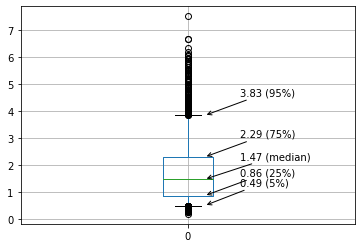

In [11]:
print('Neutrophil markers expression distribution:')
arr = neu_cells.counts[:, gene_idx].flatten()
arr = arr[arr!=0]
annotate_boxplot(pd.DataFrame(arr).boxplot(whis=[5, 95], return_type='dict'), arr)

###### 2. Conducts a comparison across all genes of 2 specified clusters: 

In [4]:
# Extract kmeans solution (K) and cluster (cls_idx) 
K_solution_1 = 11
cluster_idx_1 = 7

K_solution_2 = 11
cluster_idx_2 = 9

print(f'Conducting a comparison:')
path = join(KMEANS_PATH, f'kmeans_immune_cells_var0.315_k_{K_solution_1}.pkl')
kmeans = pickle.load(open(path, 'rb'))
cluster_1_cells = filtered_cells[kmeans['clusters'][cluster_idx_1-1]]
print('First cluster:')
print(f'K = {K_solution_1}')
print(f'cluster_idx: {cluster_idx_1}')
print(f'Number of cells: {cluster_1_cells.number_of_cells}')


path = join(KMEANS_PATH, f'kmeans_immune_cells_var0.315_k_{K_solution_2}.pkl')
kmeans = pickle.load(open(path, 'rb'))
cluster_2_cells = filtered_cells[kmeans['clusters'][cluster_idx_2-1]]
print('\nSecond cluster:')
print(f'K = {K_solution_2}')
print(f'cluster_idx: {cluster_idx_2}')
print(f'Number of cells: {cluster_2_cells.number_of_cells}')

Conducting a comparison:
First cluster:
K = 11
cluster_idx: 7
Number of cells: 7587

Second cluster:
K = 11
cluster_idx: 9
Number of cells: 2883


In [5]:
# get subset of the cluster

print(f'Number of cells in cluster {cluster_1_cells.number_of_cells}')
neutrophils_markers = 'FUT4;FCGR3B;CXCR1;CXCR2;G0S2;CSF3R;FCGR3A'
neutrophils_markers = neutrophils_markers.split(';')
gene_idx = [cluster_1_cells.gene_names.index(marker) for marker in neutrophils_markers if marker in cluster_1_cells.gene_names]
sub_cluster_1_cells = cluster_1_cells[['Neutrophils' in vv for vv in cluster_1_cells.cells_information.getattr('cell_type_list')]]
print(f'Number of cells in sub-cluster {sub_cluster_1_cells.number_of_cells}')
# Counter(cluster_1_cells.samples)

Number of cells in cluster 7587
Number of cells in sub-cluster 3411


In [11]:
Counter(cluster_1_cells.samples)
# print(cluster_1_cells.number_of_cells)


Counter({'M100': 1,
         'M101': 275,
         'M102': 2,
         'M103': 63,
         'M104': 8,
         'M105': 11,
         'M106': 22,
         'M107': 18,
         'M108': 1,
         'M109': 10,
         'M110': 222,
         'M111': 42,
         'M112': 10,
         'M114': 62,
         'M118': 12,
         'M120': 51,
         'M121': 21,
         'M122': 59,
         'M123': 1686,
         'M124': 11,
         'M126': 4,
         'M127': 2,
         'M128': 17,
         'M129': 12,
         'M130': 10,
         'M131': 3,
         'M132': 1,
         'M133': 1,
         'M134': 16,
         'M135': 19,
         'M136': 10,
         'M137': 7,
         'M138': 2,
         'M139': 8,
         'M140': 2,
         'M141': 7,
         'M143': 52,
         'M144': 23,
         'M145': 472,
         'M146': 4,
         'M97': 17,
         'M98': 15,
         'M99': 120})

Runs find_marker_genes_in_cluster using log_FC_threshold=-1000 means that there will be no filter of the direction of the marker, 
we will get highly expressed genes of cluster1 compared to cluster2 and vise versa.

In [5]:
comparison_res = find_marker_genes_in_cluster(cluster_1_cells, cluster_2_cells, log_FC_threshold=-1000, pval_threshold=0.05)

Saves results

In [18]:
comparison_res = comparison_res.rename(columns={"contaminated - mean_expression": "contaminated cells - mean_expression",
                        "cluster 9": "cluster 9 - mean_expression"})
# comparison_res.to_csv(r'/storage/md_keren/shitay/garbage/k11_gene_comparison_with_contaminated.csv', index=False)

In [20]:
comparison_res.drop(columns=['n_expressing_cells__cls1 > n_expressing_cells__cls2']).to_csv(r'/storage/md_keren/shitay/garbage/k11_gene_comparison_with_contaminated.csv', index=False)

In [25]:
comparison_res[['features', 'gene names', 'corected_pval', 'log_FC', 'contaminated cells - mean_expression',
       'cluster 9 - mean_expression']].to_csv(r'/storage/md_keren/shitay/garbage/k11_gene_comparison_with_contaminated.csv', index=False)

# Debug

In [6]:
cluster_1_cells.number_of_cells
res = cluster_1_cells.get_subset_by_identifiers(sub_cluster_1_cells.samples, sub_cluster_1_cells.barcodes)

In [24]:
df = pd.DataFrame(np.array([sub_cluster_1_cells.samples, sub_cluster_1_cells.barcodes]).T, columns=['sample', 'barcode'])

path =r'/storage/md_keren/shitay/Data/tables/stroma_contaminated_cells_kmeans_k11_cluster7_expressing_neut.csv'
df.to_csv(path, index=False)

In [12]:
mapping = list(zip(sub_cluster_1_cells.samples, sub_cluster_1_cells.barcodes))

In [16]:
mapping.index(mapping[200])


200

In [22]:
maps = list(zip(cluster_1_cells.samples, cluster_1_cells.barcodes))
dic_map = {vv: [] for vv in set(cluster_1_cells.samples)}
dic_map
for sample_id, barcode in maps:
    dic_map[sample_id].append(barcode)
dic_map

{'M127': ['CTGTTTACACCTGGTG-1', 'TAAACCGTCTCGCTTG-1'],
 'M145': ['AAAGTAGCATATGGTC-1',
  'AAATGCCTCCAGTATG-1',
  'AAATGCCTCCGTCAAA-1',
  'AACCATGGTGCAGACA-1',
  'AACCGCGGTCGATTGT-1',
  'AACTCAGTCTTGTCAT-1',
  'AACTCTTCACGACTCG-1',
  'AACTCTTCAGTACACT-1',
  'AACTCTTGTTACGACT-1',
  'AACTGGTTCTTGCAAG-1',
  'AAGACCTTCATAAAGG-1',
  'AAGGTTCAGTGCTGCC-1',
  'AAGGTTCTCTTCGGTC-1',
  'AAGTCTGGTCCGACGT-1',
  'AATCCAGCAAGGACAC-1',
  'AATCCAGGTCGCGAAA-1',
  'AATCCAGTCTTATCTG-1',
  'AATCGGTTCTAAGCCA-1',
  'AATCGGTTCTGTACGA-1',
  'ACACCAAGTGCAGACA-1',
  'ACACCAAGTTAAAGTG-1',
  'ACACCAATCGCTGATA-1',
  'ACACCCTAGGTGCTTT-1',
  'ACACCGGGTCCTGCTT-1',
  'ACACCGGTCATAAAGG-1',
  'ACACTGAGTGCAGTAG-1',
  'ACACTGATCAACCAAC-1',
  'ACAGCCGAGGCCCGTT-1',
  'ACAGCCGCATAGGATA-1',
  'ACATACGAGGTAAACT-1',
  'ACATACGGTTAAGATG-1',
  'ACATCAGCATTAGGCT-1',
  'ACATCAGTCATGCATG-1',
  'ACATCAGTCGACGGAA-1',
  'ACATCAGTCTTGTACT-1',
  'ACATGGTAGAGGTAGA-1',
  'ACGAGCCAGAAACGCC-1',
  'ACGAGGACACAAGACG-1',
  'ACGAGGAGTCATTAGC-1',
 

In [34]:
barcode_idxs = []
print([(k, len(vv)) for k,vv in dic_map.items()])
for sample_id in sorted(dic_map.keys())[:4]:
    print(sample_id)
    def myfunc(n):
        if sample_id == n[0]:
            return n[1]
        return None
#     barcode_list = [c_barcode for c_sample_id, c_barcode zip(cluster_1_cells.samples, cluster_1_cells.barcodes)]
    barcode_mask_list = list(map(myfunc, zip(cluster_1_cells.samples, cluster_1_cells.barcodes)))
    barcodes_idx = [barcode_mask_list.index(barcode) for barcode in barcode_mask_list]
    barcode_idxs += barcodes_idx
    print(barcode_mask_list)

[('M127', 2), ('M145', 472), ('M109', 10), ('M107', 18), ('M122', 59), ('M123', 1686), ('M129', 12), ('M118', 12), ('M144', 23), ('M140', 2), ('M143', 52), ('M106', 22), ('M97', 17), ('M136', 10), ('M102', 2), ('M108', 1), ('M98', 15), ('M99', 120), ('M124', 11), ('M139', 8), ('M131', 3), ('M135', 19), ('M105', 11), ('M121', 21), ('M133', 1), ('M146', 4), ('M137', 7), ('M111', 42), ('M112', 10), ('M126', 4), ('M100', 1), ('M138', 2), ('M103', 63), ('M110', 222), ('M120', 51), ('M141', 7), ('M134', 16), ('M132', 1), ('M104', 8), ('M101', 275), ('M114', 62), ('M130', 10), ('M128', 17)]
M100
['TCTATTGGTAAGTGTA-1', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [27]:
def myfunc(n):
  return len(n)

list(map(myfunc, ('apple', 'banana', 'cherry')) )

[5, 6, 6]